# <a id='toc1_'></a>[Calculate Levodopa-equivalent Daily Dose (LEDD) for BioFIND](#toc0_)

Notebook to consolidate PD medication data and calculate levodopa-equivalent daily dose (LEDD) for each BioFind participant   

**Date:** 11/3/2024  
**Author:** Marco Russo, MD, PhD 
https://github.com/dr-russo    

**Libraries**
* pandas  
* numpy  
* thefuzz  

**Data Files**  
Note, upon download, .csv file names have date of download appended as _%d%b%Y format, so adjust filenames accordingly:
* Concomitant_Medication_Log_23Mar2024.csv

Data  obtained from the Fox Investigation for New Discovery of Biomarkers  (BioFIND) database, which is part of the USC Laboratory of Neuro Imaging (LONI) Image & Data Archive (IDA), through limited Data Use Agreement: https://ida.loni.usc.edu/collaboration/access/appLicense.jsp. For up-to-date information on the study, visit [www.michaeljfox.org/biofind](www.michaeljfox.org/biofind).

**Abbreviations**  
LEDD: levdopa-equivalent daily dose
BioFIND: Fox Investigation for New Discovery of Biomarkers (BioFIND) cohort study
PD: Parkinson's disease

**Table of contents**<a id='toc0_'></a>    
- [Calculate Levodopa-equivalent Daily Dose (LEDD) for BioFIND](#toc1_)    
    - [Basic tidying of medication log](#toc1_1_1_)    
    - [Select only PD medications](#toc1_1_2_)    
    - [Calculate Levodopa equivalents](#toc1_1_3_)    
    - [Check and write to file](#toc1_1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from thefuzz import fuzz    # Correct medication names 
from thefuzz import process # Correct medication names

In [2]:
# Enable multiline outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 500)

In [3]:
# Import BioFIND concomitant medication log
cmeds = pd.read_csv(
    "Concomitant_Medication_Log_23Mar2024.csv",
    header=0,
    parse_dates=["STARTDT", "STOPDT"],
    date_format={"STARTDT": "%m-%Y", "STOPDT": "%m-%Y"},
    cache_dates=True,
    dtype={
        "PATNO": 'Int64',
        "CMTRT": str,
        "CMDOSE": float,
        "CMDOSU": str,
        "CMDOSFRQ": str,
        "ROUTE": 'Int64',
        "ONGOING": 'Int64',
        "CMINDC": str,
        "DISMED": 'Int64',
        "WHODRUG": str,
    }
).sort_values(by=["PATNO","CMTRT"])


In [ ]:
# Initial tidying of data
# Drop columns that are not needed for LEDD calculation
cmeds.drop(
    columns={
        "REC_ID",
        "PAG_NAME",
        "F_STATUS",
        "EVENT_ID",
        "CMSEQ",
        "RECNO",
        "STARTEST",
        "STOPEST",
        "SEQNO1",
        "SEQNO2",
        "EXCLMED",
        "ORIG_ENTRY",
        "LAST_UPDATE",
        "QUERY",
        "SITE_APRV"
    },
    inplace=True,
)

# Standardize NaN types
cmeds.fillna(np.nan, inplace=True)

# Check
cmeds.head()
cmeds.info()

,PATNO,CMTRT,CMDOSE,CMDOSU,CMDOSFRQ,ROUTE,STARTDT,STOPDT,ONGOING,CMINDC,DISMED,WHODRUG
7,1001,IBUPROFEN,200.0,MG,QQH,3,02/2013,02/2013,0,HEADACHE,0,IBUPROFEN
8,1001,LEVOTHYROXINE,88.0,MCG,QD,3,06/2006,NaN,1,HYPOTHYROIDISM,0,LEVOTHYROXINE
9,1001,VIBRAMYCIN,100.0,MG,QD,3,06/2008,NaN,1,ROSACEA,0,VIBRAMYCIN
5,1002,CARBIDOPA-LEVODOPA 25/100,100.0,MG,TID,3,12/2009,NaN,1,PARKINSON'S DISEASE,1,CARBIDOPA-LEVODOPA-B
6,1002,OXYBUTYNIN,20.0,MG,QD,3,07/2012,NaN,1,URINARY INCONTINENCE,0,OXYBUTYNIN


<class 'pandas.core.frame.DataFrame'>
Index: 1511 entries, 7 to 1501
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PATNO     1511 non-null   Int64  
 1   CMTRT     1511 non-null   object 
 2   CMDOSE    1504 non-null   float64
 3   CMDOSU    1506 non-null   object 
 4   CMDOSFRQ  1511 non-null   object 
 5   ROUTE     1511 non-null   Int64  
 6   STARTDT   1509 non-null   object 
 7   STOPDT    33 non-null     object 
 8   ONGOING   1511 non-null   Int64  
 9   CMINDC    1511 non-null   object 
 10  DISMED    1508 non-null   Int64  
 11  WHODRUG   1511 non-null   object 
dtypes: Int64(4), float64(1), object(7)
memory usage: 159.4+ KB


### <a id='toc1_1_1_'></a>[Basic tidying of medication log](#toc0_)
Note, within BioFIND, there are frequent typos and medication names and units are not consistent.

In [47]:
# Create dictionary to standardize medication dose units 
dict_med_units = {
    "GM": "G",
    "TABLET": "TAB",
    "GRAMS": "G",
    "APPLIC.": "APP",
    "APPL": "APP",
    "CAPSULE": "CAP",
    "DROP": "DROPS",
    "GTT": "DROPS",
    "GTTS": "DROPS",
    "CC": "ML",
    "MGQD": "MG",
    "PERCENT": "%",
    "MD": "MG",
    "MGU": "MG",
    "TBB": "TAB",
    "MCQ": "MCG",
}

In [48]:
# Convert to standardized units
cmeds.loc[:,'CMDOSU'] = cmeds['CMDOSU'].apply(lambda k: dict_med_units.get(k, k))

In [52]:
# Create dictionary of pharmacy abbreviations and standardize all medication dose frequencies to integers values 
# that indicate how many times per day medication is taken.

dict_dose_freq = {
    "QQH": 24,
    "QD": 1,
    "TID": 3,
    "QID": 4,
    "QHS": 1,
    "BID": 2,
    "DIEB. ALT.": np.nan,
    "WD": np.nan,
    "BIW": np.nan,
    "EOD": 1,
    "QW": np.nan,
    "TIW": np.nan,
    "5XD": 5,
    "QA": np.nan,
    "7QD": 7,
    "AN": np.nan,
    "6XD": 6,
    "DAILY": 1,
    "QWEEK": np.nan,
    "7/DAY": 7,
    "BD": 2,
    "5XDAY": 5,
    "QD PRN": 1,
    "QD": 1,
    "ID": np.nan,
    "QWEEK": np.nan,
    "5 X DAY": 5,
    "YEARLY": np.nan,
    "AC": 3,
    "5 TIMES A": 5,
    "Q12H": 2,
    "1X": 1,
    "BID PRN": 2,
    "TID PRN": 3,
    "QDS": 1,
    "5 X DAILY": 5,
    "1 AM, 2 PM": 2,
    " TID": 3,
    "Q3H": 6,
    "6XDAY": 6,
    "QWK": np.nan,
    "QG": np.nan,
}

In [53]:
# Use above dictionary to convert CMDOSFRQ to numeric 'doses per day'
cmeds.loc[:,'CMDOSFRQ'] = cmeds['CMDOSFRQ'].apply(lambda k: dict_dose_freq.get(k, np.nan))

### <a id='toc1_1_2_'></a>[Select only PD medications](#toc0_)

In [11]:
# Select only PD (disease meds)
pdmeds = cmeds[cmeds["DISMED"] == 1]

In [54]:
# List all unique names for PD medications 
# Requires standardization of PD medication names
pdmeds["CMTRT"].sort_values().unique()

array(['AMANTADINE', 'AZILECT', 'CARBIDOPA', 'CARBIDOPA-LEVODOPA',
       'CD/LD', 'COMTAN', 'ELDEPRYL', 'ENTACAPONE', 'LEVODOPA', 'MIRAPEX',
       'NEUPRO', 'PARCOPA', 'PRAMIPEXOLE', 'RASAGILINE', 'REQUIP',
       'ROPINIROLE', 'ROTIGOTINE', 'SELEGILINE', 'SINEMET', 'SINEMET CR',
       'STALEVO', 'TRIHEXYPHENIDYL'], dtype=object)

In [55]:
# Extract long-acting status - CR/ER/XL  

import re

target = re.compile(r"\s+(XL|CR|ER|EXTENDED RELEASE)\b", re.IGNORECASE)
pdmeds.loc[:, "LA?"] = pdmeds["CMTRT"].apply(lambda name: bool(re.search(target, name)))

In [56]:
# Provide standardized names to match all medications, correct misspellings/typos
standard_names = [
    "CARBIDOPA-LEVODOPA",
    "LEVODOPA",
    "CD/LD",
    "ROPINIROLE",
    "REQUIP",
    "NEUPRO",
    "ROTIGOTINE",
    "PRAMIPEXOLE",
    "MIRAPEX",
    "SINEMET",
    "AMANTADINE",
    "GOCOVRI",
    "AZILECT",
    "RASAGILINE",
    "ELDEPRYL",
    "SELEGILINE",
    "COMTAN",
    "ENTACAPONE",
    "OPICAPONE",
    "STALEVO",
    "PARCOPA",
    "CARBIDOPA",
    "TRIHEXYPHENIDYL"
]

In [57]:
# Fuzzy name matching to correct spelling and name variations
pdmeds.loc[:, "CMTRT"] = pdmeds["CMTRT"].apply(
    lambda x: process.extractOne(x, standard_names, scorer=fuzz.partial_ratio)[0]
)

# Check name matching
names = pdmeds["CMTRT"].unique()
print(sorted(names))

['AMANTADINE', 'AZILECT', 'CARBIDOPA-LEVODOPA', 'CD/LD', 'COMTAN', 'ELDEPRYL', 'ENTACAPONE', 'MIRAPEX', 'NEUPRO', 'PARCOPA', 'PRAMIPEXOLE', 'RASAGILINE', 'REQUIP', 'ROPINIROLE', 'ROTIGOTINE', 'SELEGILINE', 'SINEMET', 'STALEVO', 'TRIHEXYPHENIDYL']


In [64]:
# Simplify names further, avoid trade names in favor of generic names
simple_names = {
    "CARBIDOPA-LEVODOPA": "SINEMET",
    "LEVODOPA": "SINEMET",
    "CD/LD": "SINEMET",
    "PARCOPA": "SINEMET",
    "REQUIP": "ROPINIROLE",
    "MIRAPEX": "PRAMIPEXOLE",
    "COMTAN": "ENTACAPONE",
    "AZILECT": "RASAGILINE",
    "ELDEPRYL": "SELEGILINE",
    "NEUPRO": "ROTIGOTINE",
    "TRIHEXYPHENIDYL": "TRIHEXY"
}

# Substitute for standard names above
pdmeds.loc[:, "CMTRT"] = pdmeds["CMTRT"].apply(lambda x: simple_names.get(x, x))

In [65]:
# Recreate Sinemet CR as special case where long-acting (ER/CR) Sinemet used
pdmeds.loc[(pdmeds["CMTRT"] == "SINEMET") & (pdmeds["LA?"]), "CMTRT"] = "SINEMET CR"

In [66]:
# Calculate total daily dose (DD) for each medication, DD = dose x frequency
pdmeds.loc[:, "DD"] = pdmeds["CMDOSE"] * pdmeds["CMDOSFRQ"]

In [67]:
pdmeds.head()

,PATNO,CMTRT,CMDOSE,CMDOSU,CMDOSFRQ,ROUTE,STARTDT,STOPDT,ONGOING,CMINDC,DISMED,WHODRUG,LA?,MED,DD
5,1002,SINEMET,100.0,MG,3.0,3,12/2009,NaN,1,PARKINSON'S DISEASE,1,CARBIDOPA-LEVODOPA-B,False,SINEMET,300.0
93,1003,SINEMET,100.0,MG,4.0,3,01/2009,NaN,1,PARKINSON'S DISEASE,1,CARBIDOPA-LEVODOPA-B,False,SINEMET,400.0
96,1003,SINEMET,200.0,MG,1.0,3,06/2012,NaN,1,PARKINSON'S DISEASE,1,CARBIDOPA-LEVODOPA-B,False,SINEMET,200.0
94,1003,PRAMIPEXOLE,1.5,MG,4.0,3,06/2008,NaN,1,PARKINSON'S DISEASE,1,PRAMIPEXOLE DIHYDROCHLORIDE,False,PRAMIPEXOLE,6.0
98,1003,RASAGILINE,1.0,MG,1.0,3,06/2009,NaN,1,PARKINSON'S DISEASE,1,RASAGILINE MESYLATE,False,RASAGILINE,1.0


In [68]:
# Create wide table with PATNO vs. CMTRT (medications)
pdmeds_w = pdmeds.pivot_table(index="PATNO", columns="CMTRT", values="DD")
# Check
pdmeds_w.head()     

CMTRT,AMANTADINE,ENTACAPONE,PRAMIPEXOLE,RASAGILINE,ROPINIROLE,ROTIGOTINE,SELEGILINE,SINEMET,SINEMET CR,STALEVO,TRIHEXY
PATNO,,,,,,,,,,,
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.0,NaN,NaN,NaN
1003,NaN,NaN,6.0,1.0,NaN,NaN,NaN,300.0,NaN,NaN,NaN
1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,350.0,NaN,NaN,NaN
1006,NaN,NaN,NaN,NaN,6.0,NaN,NaN,600.0,NaN,NaN,NaN
1008,NaN,NaN,NaN,1.0,NaN,NaN,NaN,200.0,NaN,NaN,NaN


In [69]:
# Calculate total levodopa in either Sinemet or Stalevo
pdmeds_w["LD"] = pdmeds_w["SINEMET"] + pdmeds_w["STALEVO"] + pdmeds_w["SINEMET CR"]

### <a id='toc1_1_3_'></a>[Calculate Levodopa equivalents](#toc0_)

Levodopa equivalents are calculated similarly to Parkinson Progression Marker Initiative (PPMI) data:  
Tomlinson, C. L. et al. Systematic review of levodopa dose equivalency reporting in Parkinson’s disease. Mov. Disord. 25, 2649–2653 (2010). [https://pubmed.ncbi.nlm.nih.gov/21069833/](https://pubmed.ncbi.nlm.nih.gov/21069833/)
**Levodopa Equivalents**
| Drug | Multiplier | 
|:----|:------------|
| Levodopa | 1 | 
| Levodopa CR | 0.75 | 
| Entacapone | LD * 0.33|
| Pramipexole | 100
| Ropinirole | 20 | 
| Rotigotine | 30.3 | 
| Selegiline | 10 | 
| Rasagiline | 100 | 
| Amantadine | 1 | 
| Gocovri | 1.25 | 
| Trihexyphenidyl | 100 | 




In [45]:
# Dictionary of medications and levodopa equivalent multipliers
ldopa_equivs = {
    "SINEMET": 1.0,
    "SINEMET CR": 0.75,
    "STALEVO": 1.0,
    "PRAMIPEXOLE": 100.0,
    "ROPINIROLE": 20.0,
    "ROTIGOTINE": 30.3,
    "SELEGILINE": 10.0,
    "RASAGILINE": 100.0,
    "AMANTADINE": 1.0,
    "TRIHEXY": 100.0
}

In [70]:
# Multiply each medication total daily dose by its levodopa equivalent
for med in ldopa_equivs:
    pdmeds_w[med] = pdmeds_w[med] * ldopa_equivs.get(med, 1.0)

In [71]:
# If COMT inhibitor used, multiplly by 0.33 factor
pdmeds_w.loc[(pdmeds_w["ENTACAPONE"] > 0) | (pdmeds_w["STALEVO"] > 0), "COMT"] = (
    pdmeds_w["LD"] * 0.33
)

In [72]:
# Sum levodopa equivalents daily doses across all medications for each patient
# Exclude entacapone, Sinemet, Sinemet CR, Stalevo - already accounted for

ledd_cols = [
    "AMANTADINE",
    "PRAMIPEXOLE",
    "RASAGILINE",
    "ROPINIROLE",
    "ROTIGOTINE",
    "SELEGILINE",
    "TRIHEXY",
    "LD",
    "COMT"
]

pdmeds_w.loc[:, "LEDD"] = pdmeds_w[ledd_cols].apply(np.nansum, axis=1)

### <a id='toc1_1_4_'></a>[Check and write to file](#toc0_)

CMTRT,LEDD
count,118.000000
mean,284.786568
std,369.883320
min,0.000000
25%,100.000000
50%,200.000000
75%,390.000000
max,2800.000000


array([[<Axes: title={'center': 'LEDD'}>]], dtype=object)

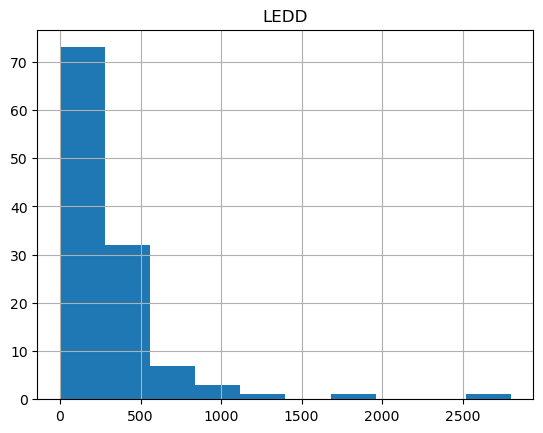

In [79]:
# Review descriptive statistics and histogram of LEDD 
pdmeds_w.describe()
pdmeds_w.hist(['LEDD'])

In [80]:
# Write to csv
pdmeds_w.to_csv("biofind_ledd.csv", index=True, columns=["LEDD"])